In [2]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
import tqdm as tqdm_notebook
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
maxAcc = 0.0
maxIter = 0
C_Lambda = 1000000
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
M = 10
PHI = []
IsSynthetic = False

In [4]:
#this function reads the file and  gets input labels as input and stores it in a vector.
def GetTargetVector(filePath):
    t = []
    #'rU' will open a file for reading in universal newline mode
    with open(filePath, 'rU') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[0]))
    #print("Raw Training Generated..")
    return t

# this function gets the input file and read the data across and rows and cols and Generates a matrix
# Matrix generated in this function is used as raw Data for this problem.
def GenerateRawData(filePath, IsSynthetic):    
    dataMatrix = [] 
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row:
                dataRow.append(float(column))
            dataMatrix.append(dataRow)   
    
    if IsSynthetic == False :
        dataMatrix = np.delete(dataMatrix, [5,6,7,8,9], axis=1)
    dataMatrix = np.transpose(dataMatrix)     
    #print ("Data Matrix Generated..")
    return dataMatrix

# this function returns 80% of the targetdata as training data output
def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

# this function returns 80% of the rawdata as training data Matrix
def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

#this function generates the validation data based on the inputdata and training count
def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

#this function generates the target vector for validation getting target vector,count and percentage as params
def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

# this function is used to generate the big sigma which is used for computing the phi value
# Big sigma determines how broad the basis function is.
def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    BigSigma    = np.zeros((len(Data),len(Data)))
    #Transposing the data matrix
    DataT       = np.transpose(Data)
    # getting the length of Training data
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    #print(len(DataT[0]))
    #the below code loops through the entire data set 41times and
    #computes the variance of each feature set of training data set
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(0.1,BigSigma)
    ##print ("BigSigma Generated..")
    return BigSigma

# this function computes the part of phi matrix calculation
# this does the job of following equation
# (X-U)T * Sigma(Inverse) * (X-U)
def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

# This is the core formula used in gaussian radial basis function
def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

# this function computes the phi matrix provided with the input features
def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    #computes the inverse of bigsigma
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

# this function computest the weights of closed form.
# The following formula is implemented in the function
# w∗ = (λI + ΦTΦ)−1ΦTt
# which is a least squared regularization
def GetWeightsClosedForm(PHI, T, Lambda):
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    return W

#This is a radial basis computation function.
#This is used for converting the phi(x) into a scalar value
def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

# this function is used for getting the output vector
# this does the following formula
# y = W * (PHI)T
def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

#This function is used to find the accuracy of the depicted output with the actual output
#It is nothing but taking ROOT MEAN SQUARE of the outputs.
def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

## Fetch and Prepare Dataset

In [5]:
#Get the rank from the csv file and store it in matrix
RawTarget = GetTargetVector('Querylevelnorm_t.csv')
# Get the features from the csv file and store it in a matrix
# if the ifSynthetic is set to false, Columns 5-9 are deleted
# Finally the input data is stored in Rawdata variable
RawData   = GenerateRawData('Querylevelnorm_X.csv',IsSynthetic)
df = pd.read_csv('Querylevelnorm_X.csv')
df.describe()


/Users/dhayanidhigunasekaran/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 'U' mode is deprecated
  """
/Users/dhayanidhigunasekaran/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: DeprecationWarning: 'U' mode is deprecated
  app.launch_new_instance()


,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.33,0.34,0.35,0.36,0.37,0.38,0.017241,0.39,0.40,0.41
count,69622.000000,69622.000000,69622.000000,69622.000000,69622.000000,69622.0,69622.0,69622.0,69622.0,69622.0,...,69622.000000,69622.000000,69622.000000,69622.000000,69622.000000,69622.000000,69622.000000,69622.000000,69622.000000,69622.000000
mean,0.161690,0.142535,0.252800,0.146084,0.165257,0.0,0.0,0.0,0.0,0.0,...,0.635138,0.569768,0.565276,0.556498,0.078532,0.101852,0.143190,0.496513,0.400360,0.000014
std,0.234703,0.255635,0.341221,0.311805,0.234518,0.0,0.0,0.0,0.0,0.0,...,0.269526,0.272595,0.284887,0.281437,0.199350,0.206043,0.248064,0.265315,0.249475,0.003790
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.019157,0.000000,0.000000,0.000000,0.021931,0.0,0.0,0.0,0.0,0.0,...,0.470615,0.383290,0.354355,0.349240,0.000421,0.003082,0.000000,0.333330,0.212770,0.000000
50%,0.063291,0.000000,0.000000,0.000000,0.067821,0.0,0.0,0.0,0.0,0.0,...,0.693540,0.613330,0.611590,0.599255,0.005494,0.023810,0.020408,0.500000,0.361110,0.000000
75%,0.190467,0.200000,0.500000,0.000000,0.196013,0.0,0.0,0.0,0.0,0.0,...,0.851457,0.782597,0.797867,0.783327,0.041172,0.090909,0.166670,0.666670,0.550730,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Prepare Training Data

In [6]:
#This functions generates the target for Training the model, which the output Y
# Training percent determines the number of records to be put in training target
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
# This is similar to the previous one, in which the entire dataset features are stored as a matrix
# The shape is 41 which means we eliminated the 5 features which are not required for computation
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

kmeans = KMeans(n_clusters=10).fit(TrainingData)


(55699,)
(41, 55699)


## Prepare Validation Data

In [7]:
# This part generates the validation data
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

(6962,)
(41, 6962)


## Prepare Test Data

In [8]:
#this part generates the test data
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

(6962,)
(41, 6962)


## Closed Form Solution [Finding Weights using Moore- Penrose pseudo- Inverse Matrix]

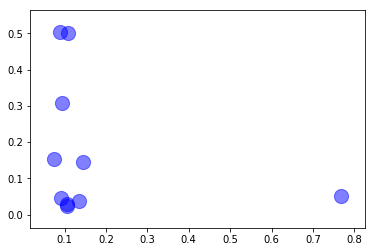

In [9]:
ErmsArr = []
AccuracyArr = []

# We use kmeans clustering to group the input values to the number of clusters.
# Number of clusters is initially set as M.
# Each input feature is clustered to M  centroids
# Mu is a matrix which contains M centroids for each input feature
# So the shape of Mu is M * 41
kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_

plt.scatter(Mu[:, 0], Mu[:, 1], c='blue', s=200, alpha=0.5);
#Big sigma is used in the phi calculation. which denotes the broadness of the basis function.
#Big sigma is calculated by finding the variance of each input data feature for all the element in training data set
#Big sigma is of the shape of 41 * 41
BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
# Training PHI
# In this problem, we have 46 input features, We need to use linear regression to compute the rank.
# Radial basis function is a real valued function which determines the distance of the point from the centroid which
# is calculated using Kmeans Clustering.
# We use gaussian radial basis function to determine the phi value.
# Phi matrix converts the 41 input features to M features
# phi matrix is of the shape (Training size * M)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
# weight vector computation
# We have the initial linear regression equation of Y = W(Transpose)*Phi
# inorder to compute the Weights, we need to compute W = phi(inverse)T * Output(T)
# Since Phi is a not a Sqaured matrix, We use Moore-penrose pseudo Inverse to compute the value of Phi+
# We use pseudoinverse because it computes the LEAST SQAURE for a system of linear equations
# There by after applying Regularization, the equation to compute weight becomes
# W* = (λI + ΦTΦ)−1ΦTt
W = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
# we compute the phi matrix for test_data similar to the one we have done for training data
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100)
# we compute the phi matrix for validation_data similar to the one we have done for training data
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)


In [10]:
print(Mu.shape)
print(BigSigma.shape)
print(TRAINING_PHI.shape)
print(W.shape)
print(VAL_PHI.shape)
print(TEST_PHI.shape)

(10, 41)
(41, 41)
(55699, 10)
(10,)
[3.17373666e-18 3.43690112e-10 5.52646988e-24 2.93872491e-09
 3.52941859e-17 4.96248765e-18 1.40902834e-24 7.85108776e-14
 2.57761595e-10 1.27547229e-14]
(6962, 10)
(6961, 10)


## Finding Erms on training, validation and test set 

In [180]:
# the below part computes the output using y = w*phi for training,validation and test

TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
print(TRAINING_PHI.shape)
print(W.shape)
print(TR_TEST_OUT.shape)
VAL_TEST_OUT = GetValTest(VAL_PHI,W)
TEST_OUT     = GetValTest(TEST_PHI,W)

#plt.scatter(TrainingTarget[1:], TR_TEST_OUT[1:], c='black', s=100, alpha=0.5)
#the Accuracy of the algorithm is computed by root mean square formula
#Sum of square of computed output - Actual output and taking a root on its mean value
TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))

(55699, 10)
(10,)
(55699,)


UBITname      = dhayanid
Person Number = 50290938
----------------------------------------------------
------------------LeToR Data------------------------
----------------------------------------------------
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
M = 10 
Lambda = 0.9
E_rms Training   = 0.6427529035300573
E_rms Validation = 0.6282628133169708
E_rms Testing    = 0.7408882410461394


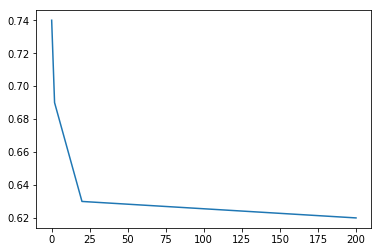

In [186]:
print ('UBITname      = dhayanid')
print ('Person Number = 50290938')
print ('----------------------------------------------------')
print ("------------------LeToR Data------------------------")
print ('----------------------------------------------------')
print ("-------Closed Form with Radial Basis Function-------")
print ('----------------------------------------------------')
print ("M = 10 \nLambda = 0.9")
print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))

sigma_value = [200,20,2,0.1]
erm_s = [0.62,0.63,0.69,0.74]
plt.plot(sigma_value,erm_s)


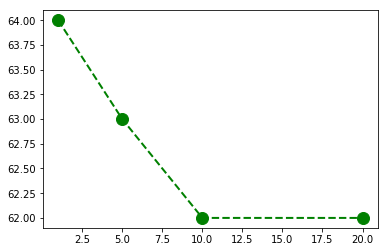

In [187]:
m_value = [1,5,10,20]
erm_m = [64,63,62,62]
plt.plot(m_value,erm_m,'go--', linewidth=2, markersize=12)



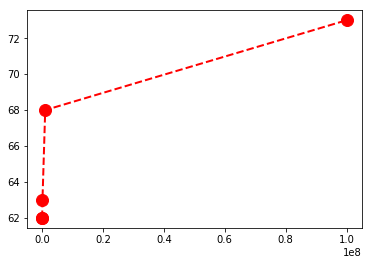

In [188]:
lambda_value = [0.1,100,100000,1000000,100000000]
erm_l = [62,62,63,68,73]
plt.plot(lambda_value,erm_l,color='red', marker='o', linestyle='dashed',linewidth=2, markersize=12)

## Gradient Descent solution for Linear Regression

In [166]:
print ('----------------------------------------------------')
print ('--------------Please Wait for 2 mins!----------------')
print ('----------------------------------------------------')

----------------------------------------------------
--------------Please Wait for 2 mins!----------------
----------------------------------------------------


In [1]:
W_Now        = np.dot(0.1, W)
La           = 2
learningRate = 0.1
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

for i in range(0,400):
    #This part of code implements the stochastic gradient descent solution for W.
    #In Stochastic gradient descent, initially the weight is set to random value
    #Then on subsequent iterations, it computes the difference between Actual and computed output
    # and determines the weight based on the learning rate.
    #This iterations goes on till we reach the convergence point.
    # The formula used in the below part of code 
    # W(t+1) = W(T) + ^w
    #^w = -n*^E
    #^E = ^Ed + lambda*^Ew
    #^Ed = - (t - w(t)T Phi(x))phi(x)
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

NameError: name 'np' is not defined

In [193]:
print ('----------Gradient Descent Solution--------------------')
print ("M = 10 \nLambda  = 0.1 \neta=0.1")
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

----------Gradient Descent Solution--------------------
M = 10 
Lambda  = 0.1 
eta=0.1
E_rms Training   = 0.64275
E_rms Validation = 0.62826
E_rms Testing    = 0.74089


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a224dbc50>],
      dtype=object)

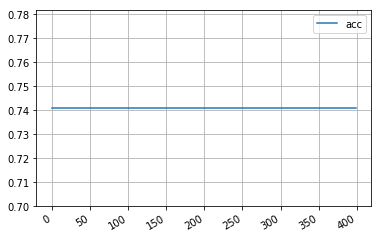

In [194]:
df = pd.DataFrame()
df['acc'] = L_Erms_Test
df.plot(subplots=True, grid=True)

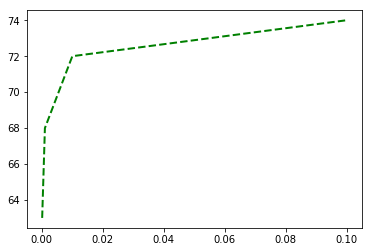

In [195]:
lambda_value = [0.0001,0.001,0.01,0.1]
erm_l = [63,68,72,74]
plt.plot(lambda_value,erm_l,color='green', linestyle='dashed',linewidth=2, markersize=12)